# I- Introduction:
Aprés avoir testé the state of the art model (Bert) nous alllons essayer dans ce projet d'utiliser deux types différents de deep neural network: Convolutional Neural Network (CNN) et Long Short Term Memory Network (LSTM), qui est une variante des Recurrent Neural Networks pour affiner rapidement et efficacement un modèle de classification des logs de Blue Gene/L supercompute, où notre objectif sera de détecter les anomalies dans des futurs logs.

* **Dataset** - nous allons utiliser une DT open Source des logs de Thunderbird supercomputer,il est sous forme d'un Filelog donc on avait besoin d'utiliser excel(On peut utiliser Python mais excel reste simple) pour insérer les logs dans des dataframes.

* **Objectif** - developper une solution qui permet de detecter les anomalies dans les logs.

* **Methodologie** - nous allons considerer comme nous avons un probleme de text classification et construire un deep learning model pour attiendre l'objectif.

# II- Different Models:

Il existe plusieurs types de modèles qui pourraient être utilisés pour créer la solution de la classification de texte parmi ces solutions on trouve:


*   **1D- Conv Net** : 
les CNN peuvent être utilisés pour la classification des textes. ils sont plus rapides à s'entraîner.

*   **Modèles basés sur RNN (LSTM, GRU)** :  ils peuvent capturer la nature séquentielle d'un texte. Mais ils sont plus lent à s'entraîner.

* **Modèles basés sur des transformers (BERT, GPT2)** -
Les modèles basés sur des transformers exploite plusieurs unités Transformer et un mécanisme d'attention à multihead.

####Dans ce projet nous allons focaliser sur un model basé sur RNN(LSTM) et un autre basé sur les CNN.


# III- Data Preprocessing

### 1. Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numpy import array
import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from sklearn.metrics import accuracy_score

###2. Loading Data

####**Importing files from Google Drive in Colab**
notre dataset est stockée dans Google Drive donc nous avons besoin de 
lier notre compte Google Drive avec notre notebook.
1. La première étape consiste à monter notre Google Drive en exécutant le code en dessous.
2.  nous obtenons le code d'autorisation en nous connectant à notre compte Google.
3.   nous collons le code d'autorisation et nous appuyons sur Entrée.

In [2]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
df1 = pd.read_csv(r'/gdrive/My Drive/t1.csv')
df2 = pd.read_csv(r'/gdrive/My Drive/t2.csv')
df3 = pd.read_csv(r'/gdrive/My Drive/t3.csv')
df4 = pd.read_csv(r'/gdrive/My Drive/t4.csv')
df5 = pd.read_csv(r'/gdrive/My Drive/t5.csv')
df6 = pd.read_csv(r'/gdrive/My Drive/t6.csv')

In [4]:
#concatinate
df=pd.concat([df1,df2,df3,df4,df5,df6])

In [6]:
def clean_data(log):
    log = re.sub("'", "", log)
    log = re.sub("-", "", log)
    log = re.sub("_", "", log)
    log = re.sub("(\\W)+", " ", log)
    log = log.lower()
    return log



In [7]:
clean_data("VAPI 1132063624 2005.11.15 dn30 Nov 15 06:07:04 dn30/dn30 kernel: [KERNEL_IB][tsIbTavorMadProcess][/mnt_projects/sysapps/src/ib/topspin/topspin-src-3.2.0-16/ib/tavor/provider/obj_host_amd64_custom1_rhel4/ts_ib_tavor/tavor_mad.c:152]InfiniHost0: EVAPI_process_local_mad failed, return code = -254 (Fatal error (Local Catastrophic Error))")

'vapi 1132063624 2005 11 15 dn30 nov 15 06 07 04 dn30 dn30 kernel kernelib tsibtavormadprocess mntprojects sysapps src ib topspin topspinsrc3 2 016 ib tavor provider objhostamd64custom1rhel4 tsibtavor tavormad c 152 infinihost0 evapiprocesslocalmad failed return code 254 fatal error local catastrophic error '

In [8]:
df['log'] = df['log'].apply(clean_data)

In [11]:
del df['Unnamed: 0']

In [12]:
df.shape

(4370918, 2)

In [13]:
df.sample(10)

,log,label
172620,1131778520 2005 11 11 dn939 nov 11 22 55 20 d...,0
276854,1131667905 2005 11 10 dn824 nov 10 16 11 45 d...,0
59151,1131757543 2005 11 11 cn554 nov 11 17 05 43 c...,0
633627,1131671971 2005 11 10 an20 nov 10 17 19 31 an...,0
372552,1131959775 2005 11 14 tbirdadmin1 nov 14 01 1...,0
862739,1131751166 2005 11 11 an138 nov 11 15 19 26 a...,0
311140,1131692329 2005 11 10 dn584 nov 10 22 58 49 d...,0
252188,1132024578 2005 11 14 bn139 nov 14 19 16 18 b...,0
156059,1131628904 2005 11 10 dn613 nov 10 05 21 44 d...,0
649059,1131671972 2005 11 10 dn533 nov 10 17 19 32 d...,0


* Vérifier les valeurs nulles

In [14]:
df.isnull().values.any()

False

* Split the dataset into train set 80% et test sets 20%)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

# IV- Preparing the Embedding Layer

nous utiliserons la classe Tokenizer du module keras.preprocessing.text pour créer un dictionnaire de word-to-index . Dans le dictionnaire, chaque mot est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé.

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Nous fixons la taille maximale à 300. Les listes de taille supérieure à 300 seront tronquées à 300. Pour les listes dont la longueur est inférieure à 300, nous ajouterons 0 à la fin de la liste jusqu'à ce qu'elle atteigne la longueur maximale.

In [17]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Nous utiliserons GloVe embeddings pour créer feature matrix, j'ai essayé d'importer Glove sur mon drive
* vous pouvez la trouver sur : https://drive.google.com/file/d/17PIgUPWrXOLFbUYqTAnl1cgWqnWHgX1B/view?usp=sharing

In [18]:
from numpy import array
from numpy import asarray
from numpy import zeros

glove_path=r'/gdrive/My Drive/glove.6B.100d.txt'
embeddings_dictionary = dict()
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Enfin, nous allons créer une embedding matrix où chaque numéro de ligne correspondra à l'index du mot. La matrice aura 100 colonnes où chaque colonne contiendra les embeddings de mots GloVe.

In [19]:
embedding_matrix = zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# V- CNN model

* Construire le model

In [20]:
from keras.layers import MaxPooling1D,Conv1D,GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Input, merge,Concatenate



###Building the Model. 
input_tensor = Input(shape=(300,))
# Créer un embedding layer(2D)
input_layer= Embedding(vocab_size,100, weights=[embedding_matrix], input_length=maxlen , trainable=False)(input_tensor)
#liste où on va stocker l'output
uni_vec = []
#nous allons utiliser 3 filtres avec des n-grams différents( 2-grams, 3-grams, 4-grams
filter_sizes = (2,3,4)
for ks in filter_sizes:
    #applique 3 convolutions différents à l'embedding layer
    conv_layer= Conv1D(128, kernel_size=ks, activation='relu')(input_layer)
    maxpool_layer = MaxPooling1D(pool_size=maxlen-ks+1,strides=None, padding='valid')(conv_layer)
    flat_layer= Flatten()(maxpool_layer)
    uni_vec.append(flat_layer)

# concatiner les outputs 
single_feature_vector = keras.layers.concatenate(uni_vec)
#fully Connected Layers
dense = Dense(128, activation='relu')(single_feature_vector)
dense2 = Dense(128, activation='relu')(dense)
out = Dense(1, activation='sigmoid')(dense2)
model = Model(inputs=input_tensor, outputs=out)



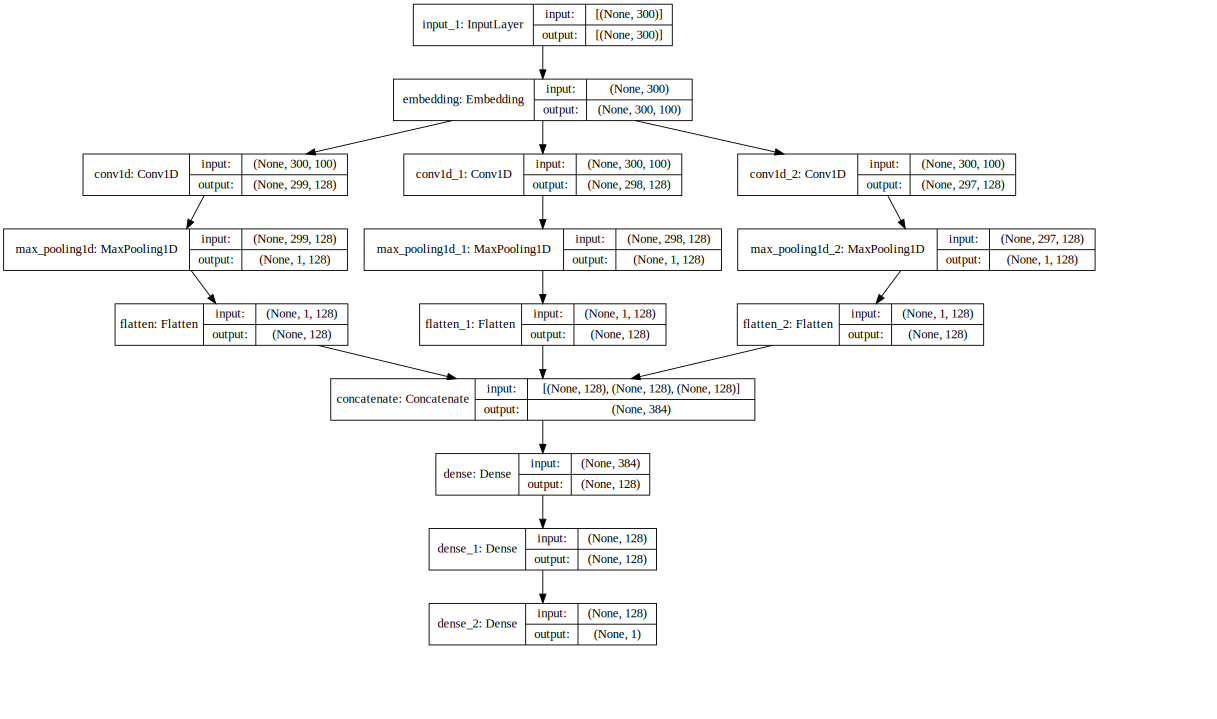

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

* compiler le model

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

* train le model

In [23]:
history = model.fit(X_train, y_train, batch_size=64, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
43710/43710 [==============================] - 2272s 51ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 1.3792e-04 - val_acc: 1.0000
Epoch 2/3
43710/43710 [==============================] - 2189s 50ms/step - loss: 1.7006e-04 - acc: 1.0000 - val_loss: 3.2620e-04 - val_acc: 1.0000
Epoch 3/3
43710/43710 [==============================] - 2180s 50ms/step - loss: 8.8628e-05 - acc: 1.0000 - val_loss: 9.4100e-07 - val_acc: 1.0000


* evaluer le model sur test set

In [24]:
score = model.evaluate(X_test, y_test, verbose=1)

27319/27319 [==============================] - 246s 9ms/step - loss: 7.0058e-06 - acc: 1.0000


In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1]) 

Test Score: 7.005797669989988e-06
Test Accuracy: 0.9999977350234985


## **Comme vous pouvez voir nous avons atteindre une performance de 99,99% avec le CNN model** 